In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
datadir='/content/drive/My Drive/CS25025/HW4/'
print(torch.__version__)
torch.cuda.is_available()

1.5.0+cu101


True

In [0]:
# Get Mnist data and split into train validation and test

In [0]:
def get_mnist():

    
    data=np.float64(np.load(datadir+'MNIST.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [0]:
# Get the data 

In [0]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    if (data_set=="cifar"):
        return(get_cifar())
    if (data_set=="mnist_transform"):
        return(get_mnist_transform())

In [0]:
# The network

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 4 x 4 = 1024 units total in final spartial layer fully connected to 256 unit later
        self.fc1 = nn.Linear(1024, 256)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(256, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 4 x 4 to 1024 units
        x = x.view(-1, 1024)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
# Run one epoch

In [0]:
def run_epoch(net,epoch,train,batch_size, num=None, ttype="train"):
    
    # Model is being trained dropout is applied
    net.train()
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0
        with tqdm(total=len(y)) as progress_bar:
            for j in np.arange(0,len(y),batch_size):
              # Transfer batch data to device (cpu or gpu)
                data=torch.torch.from_numpy(tr[j:j+batch_size]).to(device)
                targ=torch.torch.from_numpy(y[j:j+batch_size]).type(torch.long).to(device)
              # Compute gradients, update params and report loss and correct
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                
                progress_bar.set_postfix(loss=loss.item())
                progress_bar.update(data.size(0))
        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))
    return train_loss, train_correct 


In [0]:
# Run the network on a test set

In [0]:
def net_test(net,val,batch_size,ttype='val'):

    # Do not apply dropout or gradients.
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),batch_size):
                    data=torch.torch.from_numpy(vald[j:j+batch_size]).to(device)
                    targ = torch.torch.from_numpy(yval[j:j+batch_size]).type(torch.long).to(device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
    return test_loss, test_correct 

In [0]:
# Run the training. Save the model and test at the end

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_original"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
for i in range(num_epochs):
    run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,batch_size)
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

In [0]:
# Reload the model that was saved and continue training

In [0]:
batch_size=500
num_worker = 0
step_size=.001
num_epochs=0
num_train=10000
minimizer="Adam"
data_set="mnist"
new_model_name = 'mnist_model_continue'
dropout_p =.5

net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)

#load saved model
state_dict = torch.load(datadir+'models/'+ model_name, map_location = device)
net.load_state_dict(state_dict)

for i in range(num_epochs):
    run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")


net_test(net,test,batch_size, ttype="test")
#save model
if num_epochs>0:
  torch.save(net.state_dict(), datadir+ 'models/' +new_model_name)


Test set: Avg. loss: 0.0001, Accuracy: 9856/10000 (99%)



In [0]:
# starting part (a)
state_dict = torch.load(datadir+'models/'+ model_name, map_location = device)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc2.weight torch.Size([10, 256])
fc2.bias torch.Size([10])


In [0]:
# We can either sum the product of each row, or we can simply use a simple operation 
# to do the calculation for us. Indeed, the results match: there are 317066 
# parameters 

In [0]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

317066


In [0]:
# Running the model 

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_original"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


100%|██████████| 10000/10000 [00:00<00:00, 79624.27it/s, loss=0.329]



Training set epoch 0: Avg. loss: 0.0030, Accuracy: 5390/10000 (54%)


Validation set: Avg. loss: 0.0010, Accuracy: 8488/10000 (85%)


Training set epoch 1: Avg. loss: 0.0010, Accuracy: 8439/10000 (84%)



 20%|██        | 2000/10000 [00:00<00:00, 68812.10it/s, loss=0.265]


Validation set: Avg. loss: 0.0006, Accuracy: 9185/10000 (92%)


Training set epoch 2: Avg. loss: 0.0007, Accuracy: 9010/10000 (90%)


Validation set: Avg. loss: 0.0004, Accuracy: 9424/10000 (94%)



100%|██████████| 10000/10000 [00:00<00:00, 84448.34it/s, loss=0.132]



Training set epoch 3: Avg. loss: 0.0005, Accuracy: 9264/10000 (93%)


Validation set: Avg. loss: 0.0003, Accuracy: 9545/10000 (95%)


Training set epoch 4: Avg. loss: 0.0004, Accuracy: 9420/10000 (94%)



 15%|█▌        | 1500/10000 [00:00<00:00, 61551.80it/s, loss=0.114]


Validation set: Avg. loss: 0.0003, Accuracy: 9623/10000 (96%)


Training set epoch 5: Avg. loss: 0.0003, Accuracy: 9495/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9650/10000 (96%)



100%|██████████| 10000/10000 [00:00<00:00, 81453.08it/s, loss=0.105]



Training set epoch 6: Avg. loss: 0.0003, Accuracy: 9538/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9705/10000 (97%)


Training set epoch 7: Avg. loss: 0.0003, Accuracy: 9598/10000 (96%)



 15%|█▌        | 1500/10000 [00:00<00:00, 64922.62it/s, loss=0.102]


Validation set: Avg. loss: 0.0002, Accuracy: 9730/10000 (97%)


Training set epoch 8: Avg. loss: 0.0002, Accuracy: 9661/10000 (97%)


Validation set: Avg. loss: 0.0002, Accuracy: 9744/10000 (97%)



100%|██████████| 10000/10000 [00:00<00:00, 84097.67it/s, loss=0.0904]



Training set epoch 9: Avg. loss: 0.0002, Accuracy: 9690/10000 (97%)


Validation set: Avg. loss: 0.0002, Accuracy: 9763/10000 (98%)


Training set epoch 10: Avg. loss: 0.0002, Accuracy: 9684/10000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9785/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 82907.11it/s, loss=0.0523]



Training set epoch 11: Avg. loss: 0.0002, Accuracy: 9732/10000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9777/10000 (98%)


Training set epoch 12: Avg. loss: 0.0002, Accuracy: 9736/10000 (97%)



 20%|██        | 2000/10000 [00:00<00:00, 69540.56it/s, loss=0.0688]


Validation set: Avg. loss: 0.0001, Accuracy: 9780/10000 (98%)


Training set epoch 13: Avg. loss: 0.0002, Accuracy: 9762/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9809/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 83135.04it/s, loss=0.0483]



Training set epoch 14: Avg. loss: 0.0002, Accuracy: 9757/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9800/10000 (98%)


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 9769/10000 (98%)



 15%|█▌        | 1500/10000 [00:00<00:00, 65259.33it/s, loss=0.0694]


Validation set: Avg. loss: 0.0001, Accuracy: 9815/10000 (98%)


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 9785/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9818/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 84277.13it/s, loss=0.0366]



Training set epoch 17: Avg. loss: 0.0001, Accuracy: 9808/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9832/10000 (98%)


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 9804/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9825/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 82654.53it/s, loss=0.0368]



Training set epoch 19: Avg. loss: 0.0001, Accuracy: 9834/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9835/10000 (98%)


Test set: Avg. loss: 0.0001, Accuracy: 9836/10000 (98%)



In [0]:
# Train accuracy: 0.9834
# Validation accuracy of 0.98.35,
# Test accuracy of 0.9836 
# Surprisingly, these accuracy rates are very high although we used only 
# 10000 training data. Now, let's plot the error rates. 

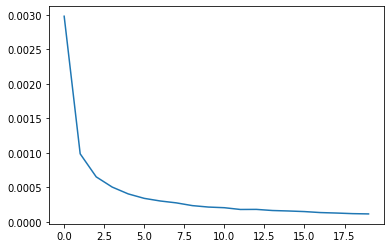

In [0]:
# Training error 
plt.plot(train_error)
plt.show()

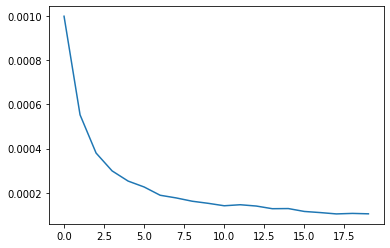

In [0]:
# Validation error 
plt.plot(val_error)
plt.show()

In [0]:
# The plots above show that the error rates decrease almost exponentially 
# as epochs proceed. Let's check out the final training and validation error rate


In [0]:
train_error[-1]

0.0001155659768730402

In [0]:
val_error[-1]

0.00010458708626683801

In [0]:
# Showing an image with the 32 5 by 5 filters that are
# estimated in the first layer of the model.

In [0]:
# function that display MNIST images

In [0]:
def display_images(image):

    img = image.reshape(28, 28)
    plt.imshow(img, interpolation="nearest", cmap="gray")

In [0]:
train[0].shape

(50000, 1, 28, 28)

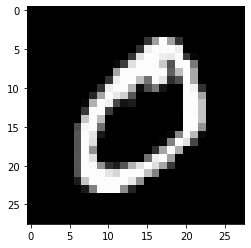

In [0]:
display_images(train[0][1])

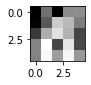

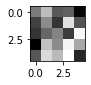

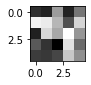

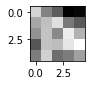

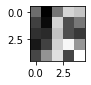

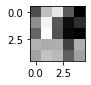

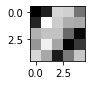

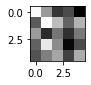

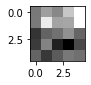

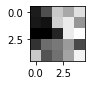

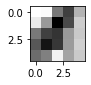

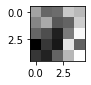

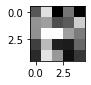

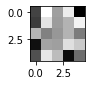

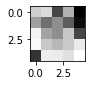

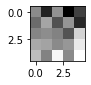

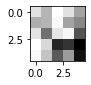

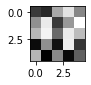

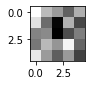

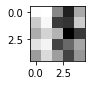

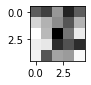

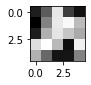

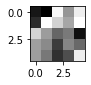

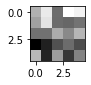

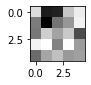

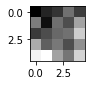

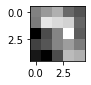

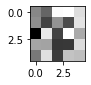

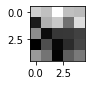

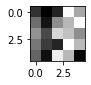

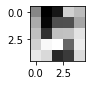

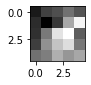

In [0]:
var = list(net.parameters())
flayer = var[0].cpu().detach().numpy()
for f in flayer:
    plt.figure(figsize=(1,1))
    plt.imshow(f[0], interpolation="nearest", cmap="gray")
    plt.show()

In [0]:
# Part (b)

In [0]:
# Part (I)

In [0]:
# Keep the same number of layers and change layer parameters reducing number of
# parameters by half in one experiment and doubling the number parameters in another. 
# Try a few different options. Report the results.

In [0]:
# reducing number of parameters by half

In [0]:
class MNIST_Net_half(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net_half, self).__init__()
        # 16 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        # 32 output features using 5x5 kernel applied to 16 features of previous layer.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 32 x 4 x 4 = 512 units total in final spartial layer fully connected to 128 unit later
        self.fc1 = nn.Linear(512, 128)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(128, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 32 x 4 x 4 to 512 units
        x = x.view(-1, 512)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
# Run the Training Model 

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_half"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net_half(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0041, Accuracy: 3480/10000 (35%)


Validation set: Avg. loss: 0.0027, Accuracy: 7122/10000 (71%)


Training set epoch 1: Avg. loss: 0.0020, Accuracy: 6970/10000 (70%)


Validation set: Avg. loss: 0.0009, Accuracy: 8759/10000 (88%)



 10%|█         | 1000/10000 [00:00<00:00, 58387.22it/s, loss=0.374]


Training set epoch 2: Avg. loss: 0.0012, Accuracy: 8258/10000 (83%)


Validation set: Avg. loss: 0.0006, Accuracy: 9159/10000 (92%)


Training set epoch 3: Avg. loss: 0.0008, Accuracy: 8739/10000 (87%)


Validation set: Avg. loss: 0.0005, Accuracy: 9324/10000 (93%)



  5%|▌         | 500/10000 [00:00<00:00, 44352.25it/s, loss=0.369]


Training set epoch 4: Avg. loss: 0.0007, Accuracy: 8933/10000 (89%)


Validation set: Avg. loss: 0.0004, Accuracy: 9398/10000 (94%)


Training set epoch 5: Avg. loss: 0.0006, Accuracy: 9103/10000 (91%)


Validation set: Avg. loss: 0.0004, Accuracy: 9446/10000 (94%)



  5%|▌         | 500/10000 [00:00<00:00, 42211.51it/s, loss=0.285]


Training set epoch 6: Avg. loss: 0.0006, Accuracy: 9167/10000 (92%)


Validation set: Avg. loss: 0.0003, Accuracy: 9517/10000 (95%)


Training set epoch 7: Avg. loss: 0.0005, Accuracy: 9267/10000 (93%)


Validation set: Avg. loss: 0.0003, Accuracy: 9560/10000 (96%)



  5%|▌         | 500/10000 [00:00<00:00, 43269.69it/s, loss=0.193]


Training set epoch 8: Avg. loss: 0.0005, Accuracy: 9309/10000 (93%)


Validation set: Avg. loss: 0.0003, Accuracy: 9597/10000 (96%)


Training set epoch 9: Avg. loss: 0.0004, Accuracy: 9357/10000 (94%)


Validation set: Avg. loss: 0.0002, Accuracy: 9615/10000 (96%)



  5%|▌         | 500/10000 [00:00<00:00, 42547.21it/s, loss=0.241]


Training set epoch 10: Avg. loss: 0.0004, Accuracy: 9440/10000 (94%)


Validation set: Avg. loss: 0.0002, Accuracy: 9653/10000 (97%)


Training set epoch 11: Avg. loss: 0.0004, Accuracy: 9432/10000 (94%)


Validation set: Avg. loss: 0.0002, Accuracy: 9690/10000 (97%)



  5%|▌         | 500/10000 [00:00<00:00, 39825.90it/s, loss=0.178]


Training set epoch 12: Avg. loss: 0.0004, Accuracy: 9465/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9681/10000 (97%)


Training set epoch 13: Avg. loss: 0.0003, Accuracy: 9524/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9699/10000 (97%)



  5%|▌         | 500/10000 [00:00<00:00, 44605.07it/s, loss=0.161]


Training set epoch 14: Avg. loss: 0.0003, Accuracy: 9534/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9717/10000 (97%)


Training set epoch 15: Avg. loss: 0.0003, Accuracy: 9526/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9712/10000 (97%)



  5%|▌         | 500/10000 [00:00<00:00, 44659.21it/s, loss=0.167]


Training set epoch 16: Avg. loss: 0.0003, Accuracy: 9570/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9740/10000 (97%)


Training set epoch 17: Avg. loss: 0.0003, Accuracy: 9586/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9749/10000 (97%)



100%|██████████| 10000/10000 [00:00<00:00, 81529.55it/s, loss=0.0996]



Training set epoch 18: Avg. loss: 0.0003, Accuracy: 9607/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9746/10000 (97%)


Training set epoch 19: Avg. loss: 0.0003, Accuracy: 9628/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9748/10000 (97%)


Test set: Avg. loss: 0.0002, Accuracy: 9784/10000 (98%)



In [0]:
# When we decreased the number of features in each layer by half, the test 
# accuracy dropped to 0.9784. So did the training and validation accuracy: they 
# all slightly decreased. The results align with our expectations because when we
# decrease the number of parameters, then we have less information at hand when
# we make predictions. However, the accuracy rates are still quite high 
# nevertheless. 

In [0]:
# Doubling the number of parameters 

In [0]:
class MNIST_Net_double(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net_double, self).__init__()
        # 64 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        # 128 output features using 5x5 kernel applied to 64 features of previous layer.
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 128 x 4 x 4 = 2048 units total in final spartial layer fully connected to 512 unit later
        self.fc1 = nn.Linear(2048, 512)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(512, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 128 x 4 x 4 to 2048 units
        x = x.view(-1, 2048)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_double"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net_double(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


 40%|████      | 4000/10000 [00:00<00:00, 37556.62it/s, loss=0.304]


Training set epoch 0: Avg. loss: 0.0022, Accuracy: 6586/10000 (66%)


Validation set: Avg. loss: 0.0006, Accuracy: 9063/10000 (91%)



 40%|████      | 4000/10000 [00:00<00:00, 37715.51it/s, loss=0.206]


Training set epoch 1: Avg. loss: 0.0006, Accuracy: 9100/10000 (91%)


Validation set: Avg. loss: 0.0004, Accuracy: 9435/10000 (94%)



 40%|████      | 4000/10000 [00:00<00:00, 37646.03it/s, loss=0.174]


Training set epoch 2: Avg. loss: 0.0004, Accuracy: 9416/10000 (94%)


Validation set: Avg. loss: 0.0002, Accuracy: 9628/10000 (96%)



 40%|████      | 4000/10000 [00:00<00:00, 37679.00it/s, loss=0.13]


Training set epoch 3: Avg. loss: 0.0003, Accuracy: 9537/10000 (95%)


Validation set: Avg. loss: 0.0002, Accuracy: 9692/10000 (97%)



 40%|████      | 4000/10000 [00:00<00:00, 37495.09it/s, loss=0.103]


Training set epoch 4: Avg. loss: 0.0002, Accuracy: 9631/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9747/10000 (97%)



 40%|████      | 4000/10000 [00:00<00:00, 37652.70it/s, loss=0.074]


Training set epoch 5: Avg. loss: 0.0002, Accuracy: 9722/10000 (97%)


Validation set: Avg. loss: 0.0002, Accuracy: 9762/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37648.73it/s, loss=0.0714]


Training set epoch 6: Avg. loss: 0.0002, Accuracy: 9737/10000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9790/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37652.79it/s, loss=0.0769]


Training set epoch 7: Avg. loss: 0.0002, Accuracy: 9770/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9810/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37664.88it/s, loss=0.0654]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 9792/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9810/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37584.88it/s, loss=0.0531]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 9826/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9821/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 38209.06it/s, loss=0.0479]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 9841/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9823/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37850.12it/s, loss=0.0491]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 9843/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9829/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37556.53it/s, loss=0.059]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 9868/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9790/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37121.10it/s, loss=0.0435]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 9857/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9836/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37500.37it/s, loss=0.0447]


Training set epoch 14: Avg. loss: 0.0001, Accuracy: 9877/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9837/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37851.65it/s, loss=0.0343]


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 9884/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9842/10000 (98%)



 40%|████      | 4000/10000 [00:00<00:00, 37591.28it/s, loss=0.0135]


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 9911/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9851/10000 (99%)



 40%|████      | 4000/10000 [00:00<00:00, 37212.66it/s, loss=0.0224]


Training set epoch 17: Avg. loss: 0.0001, Accuracy: 9906/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9851/10000 (99%)



 40%|████      | 4000/10000 [00:00<00:00, 37553.59it/s, loss=0.0241]


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 9914/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9856/10000 (99%)



100%|██████████| 10000/10000 [00:00<00:00, 37313.22it/s, loss=0.0105]



Training set epoch 19: Avg. loss: 0.0000, Accuracy: 9914/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9870/10000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9858/10000 (99%)



In [0]:
# The test accuracy is 0.9858, which is a slight increase in performance from the 
# original network. The results make sense because we have more information 
# with which we can make predictions. However, the we should note that the 
# improvement is only miniscule, and hence thetest accuracy may not increase 
# indefinitely as we increase the number of parameters. 

In [0]:
# This time, we cut the dropout probability by half and see what happens 
# to the test accuracy. 

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_drop"
dropout_p=0.25
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


100%|██████████| 10000/10000 [00:00<00:00, 83108.85it/s, loss=0.32]



Training set epoch 0: Avg. loss: 0.0028, Accuracy: 5977/10000 (60%)


Validation set: Avg. loss: 0.0009, Accuracy: 8814/10000 (88%)


Training set epoch 1: Avg. loss: 0.0009, Accuracy: 8625/10000 (86%)



 15%|█▌        | 1500/10000 [00:00<00:00, 64875.09it/s, loss=0.171]


Validation set: Avg. loss: 0.0005, Accuracy: 9240/10000 (92%)


Training set epoch 2: Avg. loss: 0.0006, Accuracy: 9151/10000 (92%)


Validation set: Avg. loss: 0.0004, Accuracy: 9451/10000 (95%)



100%|██████████| 10000/10000 [00:00<00:00, 83397.04it/s, loss=0.113]



Training set epoch 3: Avg. loss: 0.0004, Accuracy: 9370/10000 (94%)


Validation set: Avg. loss: 0.0003, Accuracy: 9549/10000 (95%)


Training set epoch 4: Avg. loss: 0.0004, Accuracy: 9483/10000 (95%)



 15%|█▌        | 1500/10000 [00:00<00:00, 65253.24it/s, loss=0.136]


Validation set: Avg. loss: 0.0002, Accuracy: 9628/10000 (96%)


Training set epoch 5: Avg. loss: 0.0003, Accuracy: 9589/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9678/10000 (97%)



100%|██████████| 10000/10000 [00:00<00:00, 84522.53it/s, loss=0.0558]



Training set epoch 6: Avg. loss: 0.0003, Accuracy: 9599/10000 (96%)


Validation set: Avg. loss: 0.0002, Accuracy: 9724/10000 (97%)


Training set epoch 7: Avg. loss: 0.0002, Accuracy: 9671/10000 (97%)


Validation set: Avg. loss: 0.0002, Accuracy: 9754/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 83637.34it/s, loss=0.0446]



Training set epoch 8: Avg. loss: 0.0002, Accuracy: 9706/10000 (97%)


Validation set: Avg. loss: 0.0002, Accuracy: 9763/10000 (98%)


Training set epoch 9: Avg. loss: 0.0002, Accuracy: 9739/10000 (97%)



 15%|█▌        | 1500/10000 [00:00<00:00, 64738.24it/s, loss=0.0642]


Validation set: Avg. loss: 0.0001, Accuracy: 9764/10000 (98%)


Training set epoch 10: Avg. loss: 0.0002, Accuracy: 9762/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9770/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 83110.99it/s, loss=0.0521]



Training set epoch 11: Avg. loss: 0.0002, Accuracy: 9767/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9783/10000 (98%)


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 9779/10000 (98%)



 15%|█▌        | 1500/10000 [00:00<00:00, 63526.32it/s, loss=0.0622]


Validation set: Avg. loss: 0.0001, Accuracy: 9771/10000 (98%)


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 9807/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9768/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 83164.05it/s, loss=0.0278]



Training set epoch 14: Avg. loss: 0.0001, Accuracy: 9827/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9801/10000 (98%)


Training set epoch 15: Avg. loss: 0.0001, Accuracy: 9823/10000 (98%)



 15%|█▌        | 1500/10000 [00:00<00:00, 63663.24it/s, loss=0.0301]


Validation set: Avg. loss: 0.0001, Accuracy: 9819/10000 (98%)


Training set epoch 16: Avg. loss: 0.0001, Accuracy: 9844/10000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9827/10000 (98%)



100%|██████████| 10000/10000 [00:00<00:00, 83207.11it/s, loss=0.0297]



Training set epoch 17: Avg. loss: 0.0001, Accuracy: 9880/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9823/10000 (98%)


Training set epoch 18: Avg. loss: 0.0001, Accuracy: 9855/10000 (99%)



100%|██████████| 10000/10000 [00:00<00:00, 85177.89it/s, loss=0.0214]



Validation set: Avg. loss: 0.0001, Accuracy: 9832/10000 (98%)


Training set epoch 19: Avg. loss: 0.0001, Accuracy: 9873/10000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9831/10000 (98%)


Test set: Avg. loss: 0.0001, Accuracy: 9849/10000 (98%)



In [0]:
# By decreasing the dropout probability, we decrease the probability that 
# an output feature is zeroed out and weights aren't updated. For this reason we 
# retrieve similar results as when we doubled the number of parameters. Test 
# accuracy slightly increased to 0.9849. 

In [0]:
# Part (II)

In [0]:
# Design a deeper network with more or less the same number of parameters as the
# original network. In order to prevent changes in the total number of parameters, 
# we simply divide the first layer with 32 features into two layers of 
# 16 features. 

In [0]:
class MNIST_Net_deeper(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net_deeper, self).__init__()
        # 16 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        # 16 output features using 5x5 kernel applied to 16 features of previous layer.
        self.conv2 = nn.Conv2d(16, 16, kernel_size=5)
        # 64 output features using 5x5 kernel applied to 16 features of previous layer.
        self.conv3 = nn.Conv2d(16, 64, kernel_size=5, stride = 1, padding = 1)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv3_drop = nn.Dropout2d(p)
        # 64 x 1 x 1 = 64 units total in final spartial layer fully connected to 16 unit later
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply second conv, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Apply third conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        # Reshape 64 x 1 x 1 to 64 units
        x = x.view(-1, 64)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_deeper"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net_deeper(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0045, Accuracy: 1666/10000 (17%)


Validation set: Avg. loss: 0.0040, Accuracy: 4639/10000 (46%)


Training set epoch 1: Avg. loss: 0.0037, Accuracy: 3223/10000 (32%)


Validation set: Avg. loss: 0.0028, Accuracy: 6026/10000 (60%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0031, Accuracy: 4357/10000 (44%)


Validation set: Avg. loss: 0.0021, Accuracy: 7055/10000 (71%)


Training set epoch 3: Avg. loss: 0.0027, Accuracy: 5054/10000 (51%)


Validation set: Avg. loss: 0.0018, Accuracy: 8047/10000 (80%)



  0%|          | 0/10000 [00:00<?, ?it/s, loss=1.06]


Training set epoch 4: Avg. loss: 0.0025, Accuracy: 5539/10000 (55%)


Validation set: Avg. loss: 0.0014, Accuracy: 8265/10000 (83%)


Training set epoch 5: Avg. loss: 0.0022, Accuracy: 5923/10000 (59%)


Validation set: Avg. loss: 0.0012, Accuracy: 8485/10000 (85%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0020, Accuracy: 6303/10000 (63%)


Validation set: Avg. loss: 0.0010, Accuracy: 8775/10000 (88%)


Training set epoch 7: Avg. loss: 0.0019, Accuracy: 6575/10000 (66%)


Validation set: Avg. loss: 0.0009, Accuracy: 8844/10000 (88%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0018, Accuracy: 6738/10000 (67%)


Validation set: Avg. loss: 0.0008, Accuracy: 9093/10000 (91%)


Training set epoch 9: Avg. loss: 0.0017, Accuracy: 6895/10000 (69%)


Validation set: Avg. loss: 0.0008, Accuracy: 9185/10000 (92%)



  0%|          | 0/10000 [00:00<?, ?it/s, loss=0.789]


Training set epoch 10: Avg. loss: 0.0016, Accuracy: 7046/10000 (70%)


Validation set: Avg. loss: 0.0007, Accuracy: 9282/10000 (93%)


Training set epoch 11: Avg. loss: 0.0016, Accuracy: 7093/10000 (71%)


Validation set: Avg. loss: 0.0006, Accuracy: 9308/10000 (93%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0015, Accuracy: 7232/10000 (72%)


Validation set: Avg. loss: 0.0006, Accuracy: 9336/10000 (93%)


Training set epoch 13: Avg. loss: 0.0014, Accuracy: 7306/10000 (73%)


Validation set: Avg. loss: 0.0005, Accuracy: 9395/10000 (94%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0014, Accuracy: 7402/10000 (74%)


Validation set: Avg. loss: 0.0005, Accuracy: 9449/10000 (94%)


Training set epoch 15: Avg. loss: 0.0014, Accuracy: 7501/10000 (75%)


Validation set: Avg. loss: 0.0004, Accuracy: 9467/10000 (95%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0013, Accuracy: 7614/10000 (76%)


Validation set: Avg. loss: 0.0004, Accuracy: 9491/10000 (95%)


Training set epoch 17: Avg. loss: 0.0013, Accuracy: 7590/10000 (76%)


Validation set: Avg. loss: 0.0004, Accuracy: 9525/10000 (95%)



100%|██████████| 10000/10000 [00:00<00:00, 81005.68it/s, loss=0.562]



Training set epoch 18: Avg. loss: 0.0012, Accuracy: 7763/10000 (78%)


Validation set: Avg. loss: 0.0004, Accuracy: 9561/10000 (96%)


Training set epoch 19: Avg. loss: 0.0012, Accuracy: 7746/10000 (77%)


Validation set: Avg. loss: 0.0004, Accuracy: 9548/10000 (95%)


Test set: Avg. loss: 0.0004, Accuracy: 9572/10000 (96%)



In [0]:
# Surprisingly, adding another layer while keeping the total 
# number of parameters more or less the same slightly decreased test accuracy
# compared to the original model. We can try a different division of layers in 
# the next experiment. Here, we divide the second layer with 64 features into 
# two layers of 32 features. 

In [0]:
class MNIST_Net_config(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net_config, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # 32 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        # 32 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv3 = nn.Conv2d(32, 32, kernel_size =5, padding = 1)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv3_drop = nn.Dropout2d(p)
        # 32 x 1 x 1 = 32 units total in final spartial layer fully connected to 32 unit later
        self.fc1 = nn.Linear(32, 32)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(32, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        # Reshape 32 x 1 x 1 to 32 units
        x = x.view(-1, 32)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set="mnist"
model_name="model_config"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net_config(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


100%|██████████| 10000/10000 [00:00<00:00, 68607.13it/s, loss=1.71]



Training set epoch 0: Avg. loss: 0.0045, Accuracy: 1601/10000 (16%)


Validation set: Avg. loss: 0.0041, Accuracy: 3994/10000 (40%)


Training set epoch 1: Avg. loss: 0.0038, Accuracy: 3194/10000 (32%)



100%|██████████| 10000/10000 [00:00<00:00, 68744.09it/s, loss=1.36]



Validation set: Avg. loss: 0.0028, Accuracy: 5863/10000 (59%)


Training set epoch 2: Avg. loss: 0.0031, Accuracy: 4437/10000 (44%)


Validation set: Avg. loss: 0.0019, Accuracy: 7241/10000 (72%)



100%|██████████| 10000/10000 [00:00<00:00, 70423.62it/s, loss=1.01]



Training set epoch 3: Avg. loss: 0.0025, Accuracy: 5365/10000 (54%)


Validation set: Avg. loss: 0.0014, Accuracy: 7922/10000 (79%)


Training set epoch 4: Avg. loss: 0.0022, Accuracy: 5910/10000 (59%)



100%|██████████| 10000/10000 [00:00<00:00, 69616.97it/s, loss=0.861]



Validation set: Avg. loss: 0.0012, Accuracy: 8648/10000 (86%)


Training set epoch 5: Avg. loss: 0.0020, Accuracy: 6407/10000 (64%)


Validation set: Avg. loss: 0.0009, Accuracy: 8944/10000 (89%)



100%|██████████| 10000/10000 [00:00<00:00, 71001.81it/s, loss=0.733]



Training set epoch 6: Avg. loss: 0.0018, Accuracy: 6816/10000 (68%)


Validation set: Avg. loss: 0.0008, Accuracy: 9188/10000 (92%)


Training set epoch 7: Avg. loss: 0.0017, Accuracy: 7067/10000 (71%)



100%|██████████| 10000/10000 [00:00<00:00, 67331.11it/s, loss=0.697]


Validation set: Avg. loss: 0.0007, Accuracy: 9304/10000 (93%)


Training set epoch 8: Avg. loss: 0.0016, Accuracy: 7230/10000 (72%)


Validation set: Avg. loss: 0.0007, Accuracy: 9371/10000 (94%)




100%|██████████| 10000/10000 [00:00<00:00, 67775.78it/s, loss=0.653]



Training set epoch 9: Avg. loss: 0.0015, Accuracy: 7292/10000 (73%)


Validation set: Avg. loss: 0.0006, Accuracy: 9440/10000 (94%)


Training set epoch 10: Avg. loss: 0.0014, Accuracy: 7527/10000 (75%)



100%|██████████| 10000/10000 [00:00<00:00, 66556.39it/s, loss=0.585]


Validation set: Avg. loss: 0.0005, Accuracy: 9510/10000 (95%)


Training set epoch 11: Avg. loss: 0.0013, Accuracy: 7631/10000 (76%)


Validation set: Avg. loss: 0.0005, Accuracy: 9511/10000 (95%)




  0%|          | 0/10000 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0013, Accuracy: 7722/10000 (77%)


Validation set: Avg. loss: 0.0004, Accuracy: 9550/10000 (96%)



100%|██████████| 10000/10000 [00:00<00:00, 70277.66it/s, loss=0.543]



Training set epoch 13: Avg. loss: 0.0012, Accuracy: 7871/10000 (79%)


Validation set: Avg. loss: 0.0004, Accuracy: 9592/10000 (96%)


Training set epoch 14: Avg. loss: 0.0012, Accuracy: 7883/10000 (79%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Validation set: Avg. loss: 0.0004, Accuracy: 9612/10000 (96%)


Training set epoch 15: Avg. loss: 0.0012, Accuracy: 7967/10000 (80%)


Validation set: Avg. loss: 0.0004, Accuracy: 9641/10000 (96%)



100%|██████████| 10000/10000 [00:00<00:00, 70601.19it/s, loss=0.526]



Training set epoch 16: Avg. loss: 0.0012, Accuracy: 7912/10000 (79%)


Validation set: Avg. loss: 0.0003, Accuracy: 9642/10000 (96%)


Training set epoch 17: Avg. loss: 0.0011, Accuracy: 8092/10000 (81%)



  0%|          | 0/10000 [00:00<?, ?it/s]


Validation set: Avg. loss: 0.0003, Accuracy: 9638/10000 (96%)


Training set epoch 18: Avg. loss: 0.0011, Accuracy: 8091/10000 (81%)


Validation set: Avg. loss: 0.0003, Accuracy: 9645/10000 (96%)



100%|██████████| 10000/10000 [00:00<00:00, 69877.93it/s, loss=0.487]



Training set epoch 19: Avg. loss: 0.0011, Accuracy: 8083/10000 (81%)


Validation set: Avg. loss: 0.0003, Accuracy: 9684/10000 (97%)


Test set: Avg. loss: 0.0003, Accuracy: 9697/10000 (97%)



In [0]:
# The results are somewhat discouraging. Although I thought adding layers itself 
# contributed to genering higher test accuracy, the results show that this is
# not necessarily true. Test accuracy was highest when we doubled the number of 
# parameters and kept the total number of layers to only two. Now, let's use this
# to test to full trainig data. 

In [0]:
# Part (III)

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=50000
minimizer="Adam"
data_set="mnist"
model_name="model_double_full"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)
# get data
train,val,test=get_data(data_set=data_set)
# Initialize the model
net = MNIST_Net_double(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
train_error = [] 
val_error  = []
for i in range(num_epochs):
    train_loss, train_correct = run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    train_error.append(train_loss)
    # Test on validation set.
    val_loss, val_correct = net_test(net,val,batch_size)
    val_error.append(val_loss)
# Test on test set.
test_loss, test_correct = net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir + 'models/' + model_name)

cuda:0
(70000, 784)


  5%|▌         | 2500/50000 [00:00<00:01, 31543.80it/s, loss=0.127]


Training set epoch 0: Avg. loss: 0.0008, Accuracy: 43709/50000 (87%)


Validation set: Avg. loss: 0.0002, Accuracy: 9759/10000 (98%)



  5%|▌         | 2500/50000 [00:00<00:01, 31701.92it/s, loss=0.08]  


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 48442/50000 (97%)


Validation set: Avg. loss: 0.0001, Accuracy: 9859/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31591.89it/s, loss=0.0931]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 48860/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9876/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31648.72it/s, loss=0.0627]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 49050/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9893/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31373.64it/s, loss=0.0541]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 49198/50000 (98%)


Validation set: Avg. loss: 0.0001, Accuracy: 9919/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31586.94it/s, loss=0.0536]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 49296/50000 (99%)


Validation set: Avg. loss: 0.0001, Accuracy: 9913/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31482.62it/s, loss=0.0458]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 49404/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9919/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31667.46it/s, loss=0.037] 


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 49472/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9926/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31511.29it/s, loss=0.0396]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 49524/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9925/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31547.79it/s, loss=0.0273]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 49511/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9928/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31406.34it/s, loss=0.0236] 


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 49589/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9933/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31913.90it/s, loss=0.0382]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 49602/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9933/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31650.25it/s, loss=0.0233]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 49648/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9937/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31480.26it/s, loss=0.0166] 


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 49676/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9941/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31556.24it/s, loss=0.035] 


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 49681/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9947/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31374.39it/s, loss=0.0122] 


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 49714/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9943/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31541.62it/s, loss=0.0172]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 49694/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9942/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31530.62it/s, loss=0.0165]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 49726/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9943/10000 (99%)



  5%|▌         | 2500/50000 [00:00<00:01, 31647.77it/s, loss=0.0131]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 49772/50000 (100%)


Validation set: Avg. loss: 0.0000, Accuracy: 9942/10000 (99%)



100%|██████████| 50000/50000 [00:01<00:00, 37524.10it/s, loss=0.0277]



Training set epoch 19: Avg. loss: 0.0000, Accuracy: 49743/50000 (99%)


Validation set: Avg. loss: 0.0000, Accuracy: 9935/10000 (99%)


Test set: Avg. loss: 0.0001, Accuracy: 9925/10000 (99%)



In [0]:
# Training the double parameter model with 50,000 (full) training data, 
# we achieved 0.9925 test accuracy which is remarkable. The results concurs with 
# our findings so far in the previous experiments. The double parameter model 
# seems to have the adequate number of layers and enough parameters to make 
# predictions with very high accuracy. 

In [0]:
# Part (c)

In [0]:
def get_mnist_transform():
    data=np.float64(np.load(datadir+'MNIST_TRANSFORM.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [0]:
def display_digit(r,c,sub):
    plt.figure(figsize=(c*2, r*2))
    for i in range(r*c):
        plt.subplot(r, c, i+1)
        plt.imshow(sub[i].reshape((28,28)), cmap='gray')
        plt.axis('off')

    plt.axis('off')
    plt.show()

In [0]:
# The first 20 digits from training data -- TRANSFORMED

(70000, 784)


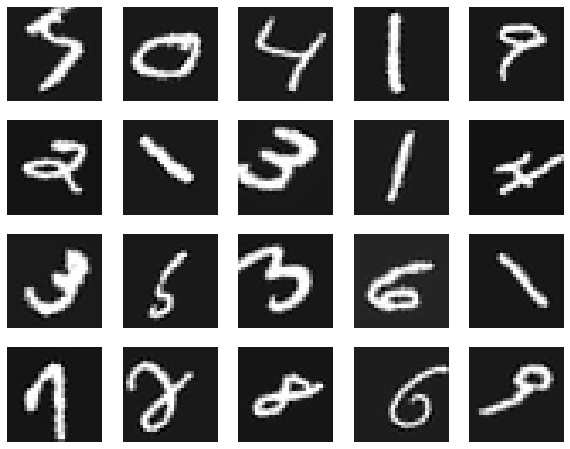

In [0]:
trans_train, trans_val, trans_test = get_mnist_transform()
display_digit(4,5, trans_train[0][:20])

In [0]:
# Original first 20 digits from the training data - UNTRANSFORMED

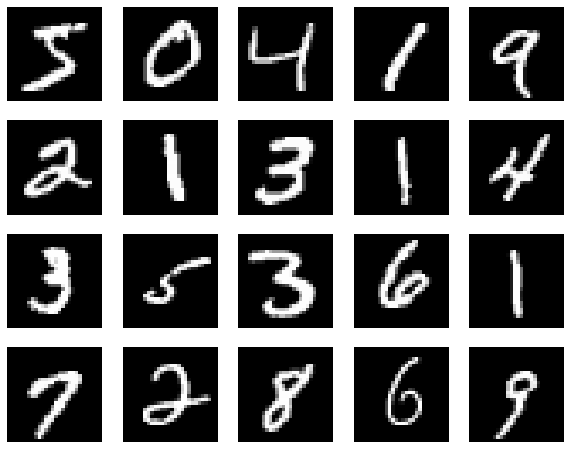

In [0]:
display_digit(4, 5, train[0][:20])

In [0]:
# If we pay close attention, we may be able to identify subtle differences between
# the two plots. However, we don't see any major transformations or manipulations.  

In [0]:
# We can use the original architecture to test on this data set. 

In [0]:
import time

# Some parameters>
batch_size=500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set = "mnist_transform"
model_name="model_original_transform"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)

# get data
train,val,test=get_data(data_set=data_set)

# Initialize the model
net = MNIST_Net(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
for i in range(num_epochs):
    run_epoch(net,i,train,batch_size, num=numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,batch_size)
# Test on test set.
net_test(net,test,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+'models/'+model_name)

cuda:0


 80%|████████  | 8000/10000 [00:00<00:00, 78837.89it/s, loss=2.3]

(70000, 784)


100%|██████████| 10000/10000 [00:00<00:00, 83585.17it/s, loss=2.3]



Training set epoch 0: Avg. loss: 0.0046, Accuracy: 1047/10000 (10%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 1: Avg. loss: 0.0046, Accuracy: 1084/10000 (11%)



 10%|█         | 1000/10000 [00:00<00:00, 55975.55it/s, loss=2.3]


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 2: Avg. loss: 0.0046, Accuracy: 1097/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 84214.18it/s, loss=2.3]



Training set epoch 3: Avg. loss: 0.0046, Accuracy: 1109/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 4: Avg. loss: 0.0046, Accuracy: 1075/10000 (11%)



 15%|█▌        | 1500/10000 [00:00<00:00, 63406.60it/s, loss=2.3]


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)


Training set epoch 5: Avg. loss: 0.0046, Accuracy: 1141/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 83942.83it/s, loss=2.3]



Training set epoch 6: Avg. loss: 0.0046, Accuracy: 1137/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 7: Avg. loss: 0.0046, Accuracy: 1125/10000 (11%)



 15%|█▌        | 1500/10000 [00:00<00:00, 63050.75it/s, loss=2.3]


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 8: Avg. loss: 0.0046, Accuracy: 1141/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 84226.02it/s, loss=2.3]



Training set epoch 9: Avg. loss: 0.0046, Accuracy: 1127/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 10: Avg. loss: 0.0046, Accuracy: 1118/10000 (11%)



 15%|█▌        | 1500/10000 [00:00<00:00, 65153.22it/s, loss=2.3]


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 11: Avg. loss: 0.0046, Accuracy: 1136/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 82983.88it/s, loss=2.3]



Training set epoch 12: Avg. loss: 0.0046, Accuracy: 1128/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 13: Avg. loss: 0.0046, Accuracy: 1130/10000 (11%)



 15%|█▌        | 1500/10000 [00:00<00:00, 64325.21it/s, loss=2.3]


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 14: Avg. loss: 0.0046, Accuracy: 1115/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 84482.02it/s, loss=2.3]



Training set epoch 15: Avg. loss: 0.0046, Accuracy: 1118/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 16: Avg. loss: 0.0046, Accuracy: 1129/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 84275.77it/s, loss=2.3]



Training set epoch 17: Avg. loss: 0.0046, Accuracy: 1120/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 18: Avg. loss: 0.0046, Accuracy: 1108/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 83497.15it/s, loss=2.3]



Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 19: Avg. loss: 0.0046, Accuracy: 1125/10000 (11%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Test set: Avg. loss: 0.0046, Accuracy: 1064/10000 (11%)



In [0]:
# The classification rate indeed drops dramatically. The test accuracy 
# decreased from 0.98 to 0.1064. 

In [0]:
# Let's propose some changes to the original architecture in order to solve this 
# problem. We can change the size of the kernels (probably increasing the size 
# of kernels). My argument is that larger filters have more power to denoise 
# spontaneous tilts and shifts of the digits. Hence, the prediction power 
# of the model will increase. 

In [0]:
class MNIST_Net_new(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net_new, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 32, kernel_size= 7)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 64, kernel_size= 5)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 3 x 3 = 576 units total in final spartial layer fully connected to 64 unit later
        self.fc1 = nn.Linear(576, 64)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(64, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
  
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 3 x 3 to 576 units
        x = x.view(-1, 576)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
# We still want to train the model on the original training set, and perform 
# some experiments on transformed validation set. Then we can test the model on  
# transformed test set.

In [0]:
import time

# Some parameters>
batch_size= 500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set_original = "mnist"
data_set_transform = "mnist_transform"
model_name="model_original_transform"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)

# get data
train_o, val_o, test_o = get_data(data_set=data_set_original)
train_t, val_t, test_t = get_data(data_set=data_set_transform)

# Initialize the model
net = MNIST_Net_new(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
for i in range(num_epochs):
    # train on original training set 
    run_epoch(net , i, train_o, batch_size, num=numtrain, ttype="train")
    # Test on transformed validation set.
    net_test(net, val_t ,batch_size)
# Test on transformed test set.
net_test(net,test_t,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+'models/'+model_name)

cuda:0
(70000, 784)


 95%|█████████▌| 9500/10000 [00:00<00:00, 88312.29it/s, loss=1.29]

(70000, 784)


  0%|          | 0/10000 [00:00<?, ?it/s, loss=0.685]


Training set epoch 0: Avg. loss: 0.0038, Accuracy: 3507/10000 (35%)


Validation set: Avg. loss: 0.0046, Accuracy: 980/10000 (10%)


Training set epoch 1: Avg. loss: 0.0019, Accuracy: 6903/10000 (69%)


Validation set: Avg. loss: 0.0046, Accuracy: 1213/10000 (12%)



  5%|▌         | 500/10000 [00:00<00:00, 49593.30it/s, loss=0.485]


Training set epoch 2: Avg. loss: 0.0012, Accuracy: 8149/10000 (81%)


Validation set: Avg. loss: 0.0046, Accuracy: 1164/10000 (12%)


Training set epoch 3: Avg. loss: 0.0010, Accuracy: 8533/10000 (85%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



  0%|          | 0/10000 [00:00<?, ?it/s, loss=0.312]


Training set epoch 4: Avg. loss: 0.0008, Accuracy: 8825/10000 (88%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 5: Avg. loss: 0.0007, Accuracy: 8989/10000 (90%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



  0%|          | 0/10000 [00:00<?, ?it/s, loss=0.264]


Training set epoch 6: Avg. loss: 0.0006, Accuracy: 9072/10000 (91%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 7: Avg. loss: 0.0006, Accuracy: 9209/10000 (92%)


Validation set: Avg. loss: 0.0046, Accuracy: 1153/10000 (12%)



  5%|▌         | 500/10000 [00:00<00:00, 46580.61it/s, loss=0.24]


Training set epoch 8: Avg. loss: 0.0005, Accuracy: 9263/10000 (93%)


Validation set: Avg. loss: 0.0046, Accuracy: 1184/10000 (12%)


Training set epoch 9: Avg. loss: 0.0005, Accuracy: 9336/10000 (93%)


Validation set: Avg. loss: 0.0046, Accuracy: 1670/10000 (17%)



  5%|▌         | 500/10000 [00:00<00:00, 50491.20it/s, loss=0.222]


Training set epoch 10: Avg. loss: 0.0004, Accuracy: 9376/10000 (94%)


Validation set: Avg. loss: 0.0046, Accuracy: 1157/10000 (12%)


Training set epoch 11: Avg. loss: 0.0004, Accuracy: 9416/10000 (94%)


Validation set: Avg. loss: 0.0046, Accuracy: 1187/10000 (12%)



  5%|▌         | 500/10000 [00:00<00:00, 48436.43it/s, loss=0.239]


Training set epoch 12: Avg. loss: 0.0004, Accuracy: 9413/10000 (94%)


Validation set: Avg. loss: 0.0046, Accuracy: 1420/10000 (14%)


Training set epoch 13: Avg. loss: 0.0004, Accuracy: 9437/10000 (94%)


Validation set: Avg. loss: 0.0046, Accuracy: 1010/10000 (10%)



  5%|▌         | 500/10000 [00:00<00:00, 46427.98it/s, loss=0.171]


Training set epoch 14: Avg. loss: 0.0004, Accuracy: 9491/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 1062/10000 (11%)


Training set epoch 15: Avg. loss: 0.0003, Accuracy: 9508/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 892/10000 (9%)



  5%|▌         | 500/10000 [00:00<00:00, 48764.17it/s, loss=0.166]


Training set epoch 16: Avg. loss: 0.0003, Accuracy: 9521/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 892/10000 (9%)


Training set epoch 17: Avg. loss: 0.0003, Accuracy: 9556/10000 (96%)


Validation set: Avg. loss: 0.0046, Accuracy: 892/10000 (9%)



100%|██████████| 10000/10000 [00:00<00:00, 90670.01it/s, loss=0.117]



Training set epoch 18: Avg. loss: 0.0003, Accuracy: 9575/10000 (96%)


Validation set: Avg. loss: 0.0046, Accuracy: 1298/10000 (13%)


Training set epoch 19: Avg. loss: 0.0003, Accuracy: 9558/10000 (96%)


Validation set: Avg. loss: 0.0046, Accuracy: 1366/10000 (14%)


Test set: Avg. loss: 0.0046, Accuracy: 1447/10000 (14%)



In [0]:
# When we changed the kernel size of the first layer to [7,7], the 
# test accuracy on the transformed data set increased to 0.1447 from 0.1064. 
# Let's try changing the kernel size of the second layer and see if it further 
# increases the accuracy rate. 

In [0]:
class MNIST_Net_new2(nn.Module):
    def __init__(self,p=0.5,minimizer='Adam'):
        super(MNIST_Net_new2, self).__init__()
        # 32 output features using 5x5 kernel applied to input image
        self.conv1 = nn.Conv2d(1, 32, kernel_size= 7)
        # 64 output features using 5x5 kernel applied to 32 features of previous layer.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        # Dropout - zero out some output features so weights aren't updated.
        self.conv2_drop = nn.Dropout2d(p)
        # 64 x 2 x 2 = 256 units total in final spartial layer fully connected to 64 unit later
        self.fc1 = nn.Linear(256, 64)
        # Last layer has 10 units for 10 classes
        self.fc2 = nn.Linear(64, 10)
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        # negative log-likelihood loss 
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        # Apply first conv then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
  
        # Apply second conv then drop, then maxpool by factor of 2 then non-linearity relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Reshape 64 x 2 x 2 to 256 units
        x = x.view(-1, 256)
        # Apply fully connected layer with non-linearity relu
        x = F.relu(self.fc1(x))
        # Another dropout
        x = F.dropout(x, training=self.training)
        # Final 10 unit logits layer
        x = self.fc2(x)
        return x
    
    def get_acc_and_loss(self, data, targ):
        # Apply network to batch input
        output = self.forward(data)
        # Comput loss between logit output and targ (correct class labels)
        loss = self.criterion(output, targ)
        # Also compute correct classification rate
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        # Compute loss and accuracy
        loss, correct=self.get_acc_and_loss(data,targ)
        # Zero out gradients
        self.optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters based on gradients
        self.optimizer.step()
        
        return loss, correct
    
        

In [0]:
import time

# Some parameters>
batch_size= 500
step_size=.001
num_epochs=20
numtrain=10000
minimizer="Adam"
data_set_original = "mnist"
data_set_transform = "mnist_transform"
model_name="model_original_transform"
dropout_p=0.5
dim=28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'
print(device)

# get data
train_o, val_o, test_o = get_data(data_set=data_set_original)
train_t, val_t, test_t = get_data(data_set=data_set_transform)

# Initialize the model
net = MNIST_Net_new2(p = dropout_p, minimizer=minimizer)
net.to(device)
#define optimizer

# Run epochs
for i in range(num_epochs):
    # train on original training set 
    run_epoch(net , i, train_o, batch_size, num=numtrain, ttype="train")
    # Test on transformed validation set.
    net_test(net, val_t ,batch_size)
# Test on transformed test set.
net_test(net,test_t,batch_size,ttype='test')
# Save model
torch.save(net.state_dict(), datadir+'models/'+model_name)

cuda:0
(70000, 784)


 75%|███████▌  | 7500/10000 [00:00<00:00, 73532.34it/s, loss=1.63]

(70000, 784)


100%|██████████| 10000/10000 [00:00<00:00, 79038.34it/s, loss=0.744]



Training set epoch 0: Avg. loss: 0.0039, Accuracy: 3565/10000 (36%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 1: Avg. loss: 0.0020, Accuracy: 6762/10000 (68%)



 10%|█         | 1000/10000 [00:00<00:00, 53262.36it/s, loss=0.621]


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 2: Avg. loss: 0.0013, Accuracy: 7996/10000 (80%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 78730.05it/s, loss=0.355]



Training set epoch 3: Avg. loss: 0.0010, Accuracy: 8450/10000 (84%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 4: Avg. loss: 0.0009, Accuracy: 8709/10000 (87%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)



100%|██████████| 10000/10000 [00:00<00:00, 79614.30it/s, loss=0.318]



Training set epoch 5: Avg. loss: 0.0008, Accuracy: 8899/10000 (89%)


Validation set: Avg. loss: 0.0046, Accuracy: 1135/10000 (11%)


Training set epoch 6: Avg. loss: 0.0007, Accuracy: 8994/10000 (90%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)



100%|██████████| 10000/10000 [00:00<00:00, 78963.79it/s, loss=0.253]



Training set epoch 7: Avg. loss: 0.0006, Accuracy: 9129/10000 (91%)


Validation set: Avg. loss: 0.0046, Accuracy: 1552/10000 (16%)


Training set epoch 8: Avg. loss: 0.0006, Accuracy: 9150/10000 (92%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)



100%|██████████| 10000/10000 [00:00<00:00, 80287.74it/s, loss=0.18]



Training set epoch 9: Avg. loss: 0.0005, Accuracy: 9228/10000 (92%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)


Training set epoch 10: Avg. loss: 0.0005, Accuracy: 9310/10000 (93%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)



100%|██████████| 10000/10000 [00:00<00:00, 80364.97it/s, loss=0.181]



Training set epoch 11: Avg. loss: 0.0005, Accuracy: 9332/10000 (93%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)


Training set epoch 12: Avg. loss: 0.0004, Accuracy: 9378/10000 (94%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)



100%|██████████| 10000/10000 [00:00<00:00, 78820.74it/s, loss=0.143]



Training set epoch 13: Avg. loss: 0.0004, Accuracy: 9448/10000 (94%)


Validation set: Avg. loss: 0.0046, Accuracy: 1368/10000 (14%)


Training set epoch 14: Avg. loss: 0.0004, Accuracy: 9467/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 1411/10000 (14%)



100%|██████████| 10000/10000 [00:00<00:00, 78275.16it/s, loss=0.128]



Training set epoch 15: Avg. loss: 0.0004, Accuracy: 9497/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)


Training set epoch 16: Avg. loss: 0.0004, Accuracy: 9492/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 1028/10000 (10%)



100%|██████████| 10000/10000 [00:00<00:00, 78848.16it/s, loss=0.148]



Training set epoch 17: Avg. loss: 0.0003, Accuracy: 9522/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 1131/10000 (11%)


Training set epoch 18: Avg. loss: 0.0003, Accuracy: 9533/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 980/10000 (10%)



100%|██████████| 10000/10000 [00:00<00:00, 79642.11it/s, loss=0.122]



Training set epoch 19: Avg. loss: 0.0003, Accuracy: 9534/10000 (95%)


Validation set: Avg. loss: 0.0046, Accuracy: 1322/10000 (13%)


Test set: Avg. loss: 0.0046, Accuracy: 1357/10000 (14%)



In [0]:
# Interestingly, test accuracy on the transformed data set slightly decreased 
# when we increased the kernel size for both layers. Perhaps when we have too 
# large, or too many layers with large filters, the original image is diluted 
# and the density of information decreases. 
# In conclusion, using the new architecture with the highest test accuracy in the 
# above experiments, the final result turned out to be 0.1447 test accuracy, 
# which is indeed a significant improvement from the previous 0.1064 test accuracy 
# using the original architecture. 